# Training Notebook

First the imports:

In [1]:
# Import our module containing helper functions
import gravann
import gravann.polyhedral

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:131: PyVistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyVistaDeprecationWarning)


Available devices  1
__pyTorch VERSION: 1.13.1
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


## 0 - Loading the ground truth (both mascon and polyhedral)

In [2]:
##################### PLEASE SPECIFY THIS ####################
# one of "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
SAMPLE_NAME = "churyumov-gerasimenko"
# can be freely chosen
MODEL_NAME = "second"
# either 'mascon' or 'polyhedral'
MODEL_METHOD = 'polyhedral'

# Load an already trained and saved model (e.g. for re-training)?
LOAD_TRAINED = False
##############################################################

MODEL_FILENAME = f"models_polyhedral/{SAMPLE_NAME}_{MODEL_METHOD}_{MODEL_NAME}.mdl"

mesh_vertices, mesh_faces = gravann.load_polyhedral_mesh(SAMPLE_NAME)
density = gravann.polyhedral.calculate_density(mesh_vertices, mesh_faces)

# Only for the legacy plots required
mascon_points, mascon_masses = gravann.load_mascon_data(SAMPLE_NAME)

print(f"Chosen body: {SAMPLE_NAME}")
print(f"Loaded Polyhedral Mesh Data:")
print(f"Loaded the Mesh of {SAMPLE_NAME}")
print(f"Number of vertices: {len(mesh_vertices)}")
print(f"Number of faces (triangles): {len(mesh_faces)}")
print(f"Calculated Density: {density}")

Chosen body: churyumov-gerasimenko
Loaded Polyhedral Mesh Data:
Loaded the Mesh of churyumov-gerasimenko
Number of vertices: 9149
Number of faces (triangles): 18294
Calculated Density: 1.6605502606980964


## 1 - Defining the network architecture
We here use functions from our module as to not clutter the notebook, but the code is rather straight forward: a FFNN with some options.

In [3]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.SquaredReLU())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = torch.nn.ReLU())


# Init training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
weighted_average = deque([], maxlen=20)

if LOAD_TRAINED:
    model.load_state_dict(torch.load(MODEL_FILENAME))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
c = gravann.compute_c_for_model_v2(model, encoding, MODEL_METHOD,
                                   mascon_points=mascon_points,
                                   mascon_masses=mascon_masses,
                                   mesh_vertices=mesh_vertices,
                                   mesh_faces=mesh_faces,
                                   density=density,
                                   use_acc = True)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2 - Visualizing the initial neural density field
The network output is a mass density in the unit cube. Essentially a three dimensional function which we here plot via rejection sampling (for now this method is good enough)

Sampling points...: 10207it [00:04, 2171.18it/s]                                                                       


<IPython.core.display.Javascript object>


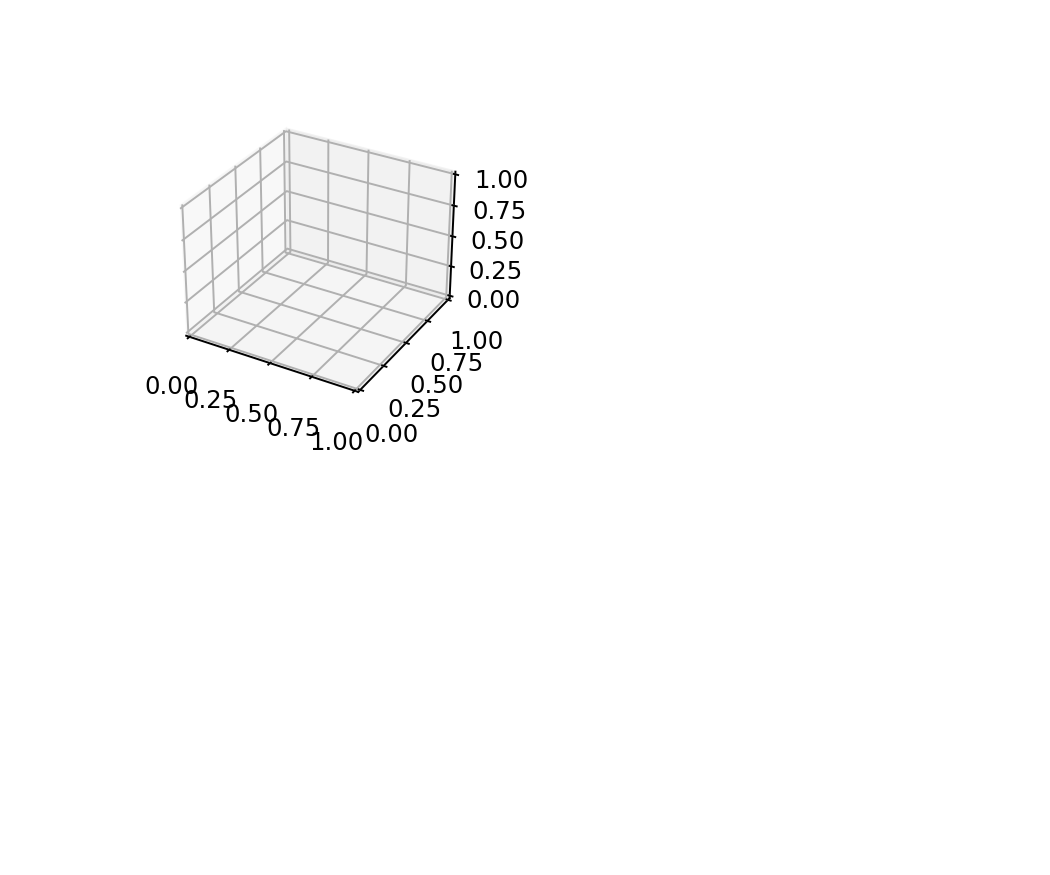

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [11]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=True, N=10000, progressbar=True, c=c)
plt.title("Believe it or not I am an asteroid!")

# 3- Training of a geodesyNet
Specify parameters if you're unhappy with the defaults

In [5]:
##################### PLEASE SPECIFY THIS ####################
# Number of iterations to train
NUMBER_OF_ITERATIONS = 1000

# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
N_QUADRATUR = 30000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
BATCH_SIZE = 1000

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
LOSS_FN = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
MC_METHOD = gravann.ACC_trap

# Here we set the optimizer
LEARNING_RATE = 1e-4
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER,factor = 0.8, patience = 200, min_lr = 1e-6,verbose=True)

##############################################################

LABEL_FUNCTIONS = {
    'polyhedral': lambda points: gravann.polyhedral.ACC_L(points, mesh_vertices, mesh_faces, density),
    'mascon': lambda points: gravann.ACC_L(points, mascon_points, mascon_masses)
}

label_fn = LABEL_FUNCTIONS[MODEL_METHOD]

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
# Only for sampling the low poly resolution!!
targets_point_sampler = gravann.get_target_point_sampler(BATCH_SIZE,
                                                         limit_shape_to_asteroid=f"./3dmeshes/{SAMPLE_NAME}_lp.pk",
                                                         method="spherical",
                                                         bounds=[0,1])

**Note: the cell below is explicitly typed for convenience, as this is a tutorial-ish after all, but the module gravann contains a function (train_on_batch) that does the same**

In [6]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(NUMBER_OF_ITERATIONS):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = label_fn(target_points)
    
    # We compute the values predicted by the neural density field
    predicted = MC_METHOD(target_points, model, encoding, N=N_QUADRATUR, noise=0.)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if LOSS_FN == gravann.contrastive_loss:
       loss = LOSS_FN(predicted, labels)
    else:
       loss = LOSS_FN(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
        # Uncomment to save the model during training (careful it overwrites the model folder)
        #torch.save(model.state_dict(), "models/"+name_of_gt+".mdl")
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((N_QUADRATUR*BATCH_SIZE) // 1000000) #counted in millions
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    OPTIMIZER.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    OPTIMIZER.step()
    
    # Perform a step in LR scheduler to update LR
    SCHEDULER.step(loss.item())

New Best:  0.36295706033706665
It=0	 loss=3.630e-01	  weighted_average=3.630e-01	  c=5.549e+00
New Best:  0.3328711688518524
New Best:  0.3112766444683075
New Best:  0.29065176844596863
New Best:  0.26684096455574036
New Best:  0.22373473644256592
New Best:  0.20790234208106995
New Best:  0.17730598151683807
New Best:  0.1771971434354782
New Best:  0.15044331550598145
New Best:  0.14169646799564362
New Best:  0.12013152241706848
It=25	 loss=1.201e-01	  weighted_average=2.402e-01	  c=5.933e+00
New Best:  0.10375618189573288
New Best:  0.09613747149705887
New Best:  0.08559668064117432
New Best:  0.07397030293941498
New Best:  0.0641275942325592
New Best:  0.05634357035160065
New Best:  0.04856766760349274
New Best:  0.04339433088898659
New Best:  0.037344884127378464
New Best:  0.03315495327115059
New Best:  0.03224717825651169
It=50	 loss=4.067e-02	  weighted_average=5.733e-02	  c=5.536e+00
New Best:  0.029836514964699745
New Best:  0.029231781139969826
New Best:  0.0273414459079504
Ne

In [7]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

# 3 - Interpretation of the neural density field learned

<IPython.core.display.Javascript object>


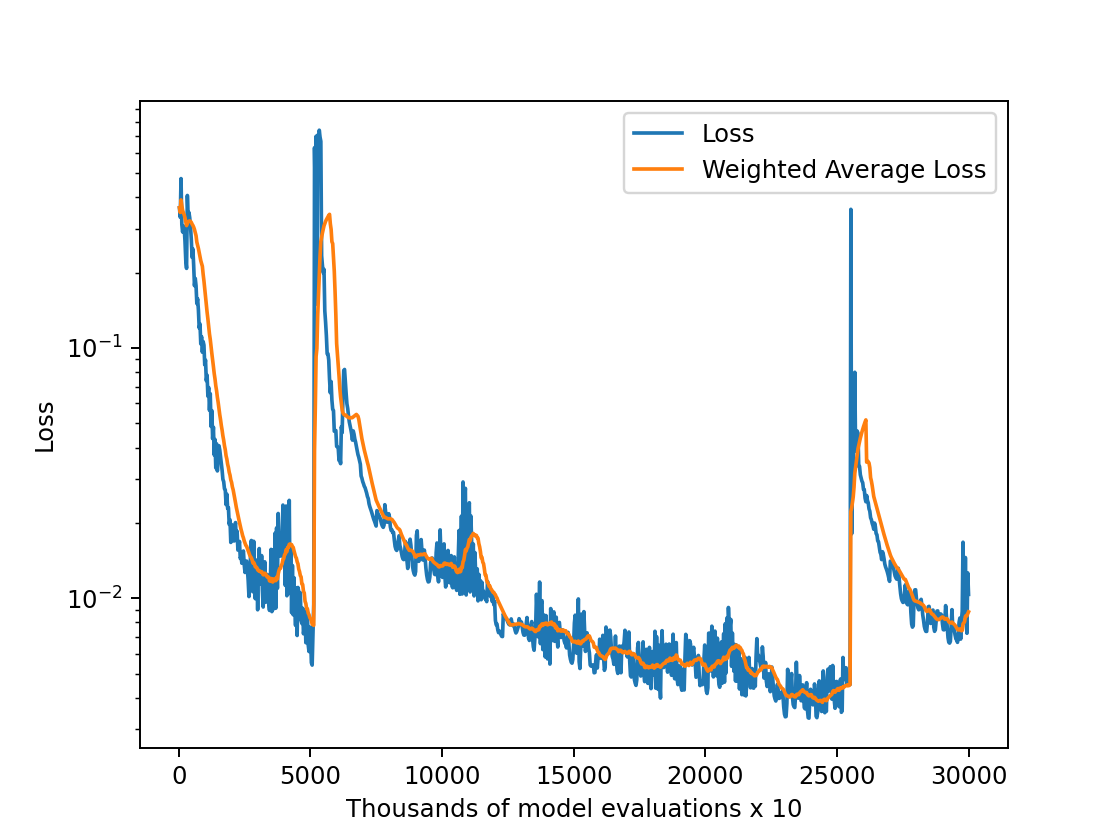

In [8]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa,  loss_log)
plt.semilogy(abscissa,  weighted_average_log)
plt.xlabel("Thousands of model evaluations x 10")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1509it [00:00, 2510.73it/s]                                                                        


<IPython.core.display.Javascript object>


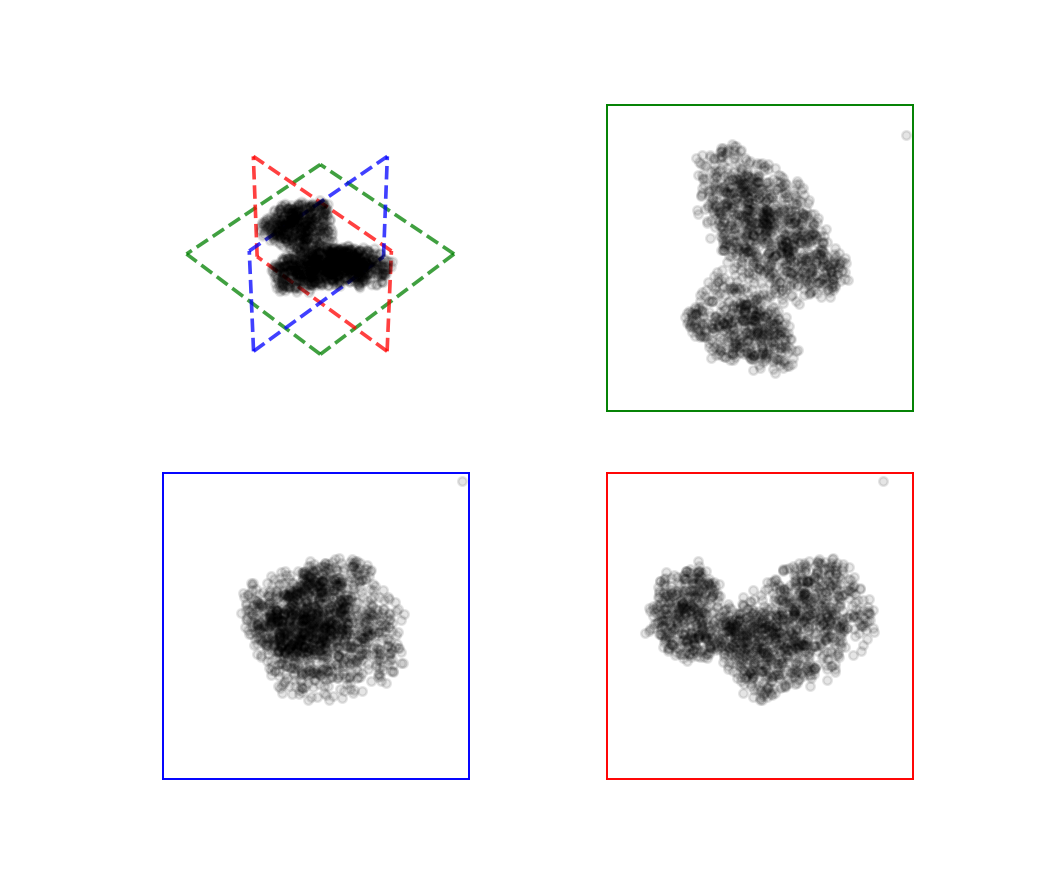

<IPython.core.display.Javascript object>


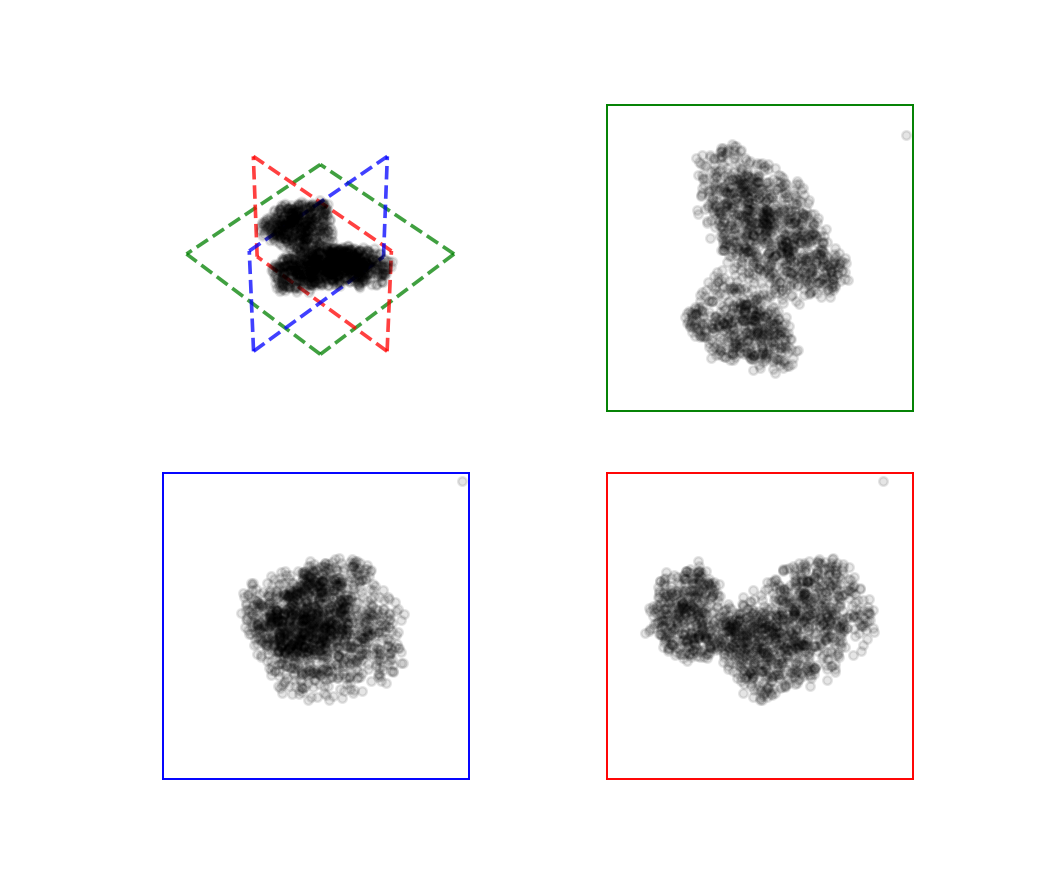

In [9]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

#### Saving the model

In [10]:
# Uncomment to save the model
torch.save(model.state_dict(), MODEL_FILENAME)